# k-means with text data

In [123]:
import graphlab
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import os

## Load data, extract features

In [2]:
wiki = graphlab.SFrame("E:\\Machine Learning\\U.W\\Cluster and Retrieval\\people_wiki.gl/")

This non-commercial license of GraphLab Create for academic use is assigned to lxn1021@gmail.com and will expire on November 18, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Xiaoning\AppData\Local\Temp\graphlab_server_1555254371.log.0


In [3]:
wiki.head()

URI,name,text
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


In [4]:
wiki["tf_idf"] = graphlab.text_analytics.tf_idf(wiki["text"])

In [5]:
wiki.head()

URI,name,text,tf_idf
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'since':1.455376717308041, ..."
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'precise':6.44320060695519, ..."
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'just':2.7007299687108643, ..."
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"{'all':1.6431112434912472, ..."
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"{'legendary':4.280856294365192, ..."
<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...,"{'now': 1.96695239252401,'currently': ..."
<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...,"{'exclusive':10.455187230695827, ..."
<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...,"{'taxi':6.0520214560945025, ..."
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"{'houston':3.935505942157149, ..."
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"{'phenomenon':5.750053426395245, ..."


In [26]:
def sframe_to_scipy(x, column_name):
    x = x.add_row_number()
    x = x.stack(column_name, ["feature", "value"])
    
    f = graphlab.feature_engineering.OneHotEncoder(features = ["feature"])
    f.fit(x)
    x = f.transform(x)
    
    mapping = f["feature_encoding"]
    
    x["feature_id"] = x["encoded_features"].dict_keys().apply(lambda x: x[0])
    
    i = np.array(x["id"])
    j = np.array(x["feature_id"])
    v = np.array(x["value"])
    width = x["id"].max() + 1
    height = x["feature_id"].max() + 1
    
    mat = csr_matrix((v, (i, j)), shape = (width, height))
    
    
    return mat, mapping

In [28]:
tf_idf, map_index_to_word = sframe_to_scipy(wiki, "tf_idf")

In [29]:
tf_idf

<59071x547979 sparse matrix of type '<type 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [30]:
map_index_to_word

feature,category,index
feature,bioarchaeologist,0
feature,leaguehockey,1
feature,electionruss,2
feature,teramoto,3
feature,trumpeterpercussionist,4
feature,spoofax,5
feature,mendelssohni,6
feature,crosswise,7
feature,yec,8
feature,asianthemed,9


The above matrix contains a TF-IDF score for each of the 59071 pages in the data set and each of the 547979 unique words.

## Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

In [31]:
from sklearn.preprocessing import normalize

In [32]:
tf_idf = normalize(tf_idf)

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [45]:
def get_initial_centroids(data, k, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    n = data.shape[0]
    
    # Pick k indices from range [0, N]
    rand_indices = np.random.randint(0, n, k)
    
    centroids = data[rand_indices, :].toarray()
    
    
    return centroids

In [48]:
get_initial_centroids(tf_idf, k=3, seed=0)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.09601960e-04, 1.65666591e-04, 3.17131840e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.11330592e-04, 5.15579651e-05, 1.87423195e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.43559145e-05, 9.94403808e-05, 8.13341373e-06]])

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

### Assigning clusters

In [53]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102, :]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric = "euclidean")

print dist

[[1.41000789 1.36894636]
 [1.40935215 1.41023886]
 [1.39855967 1.40890299]
 ...
 [1.41108296 1.39123646]
 [1.41022804 1.31468652]
 [1.39899784 1.41072448]]


More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

**Checkpoint:** For a moment, suppose that we initialize three centroids with the first 3 rows of `tf_idf`. Write code to compute distances from each of the centroids to all data points in `tf_idf`. Then find the distance between row 430 of `tf_idf` and the second centroid and save it to `dist`.

In [65]:
initial_centroids = tf_idf[:3, :]
dist_all = pairwise_distances(tf_idf, initial_centroids, metric="euclidean")
dist = pairwise_distances(tf_idf[430, :], initial_centroids[1])

In [66]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Next, given the pairwise distances, we take the minimum of the distances for each data point.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint and save them as `distances`. The value 0 indicates closeness to the first centroid, 1 indicates closeness to the second centroid, and so forth. Save this array as `closest_cluster`.

In [73]:
distances = pairwise_distances(tf_idf, initial_centroids, metric="euclidean")
closest_cluster = np.argmin(distances, axis=1)

In [74]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Let's put these steps together.  First, initialize three centroids with the first 3 rows of `tf_idf`. Then, compute distances from each of the centroids to all data points in `tf_idf`. Finally, use these distance calculations to compute cluster assignments and assign them to `cluster_assignment`.

In [75]:
initial_centroids = tf_idf[:3, :]
distances = pairwise_distances(tf_idf, initial_centroids, metric = "euclidean")
cluster_assignment = np.argmin(distances, axis=1)

In [76]:
if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


Now we are ready to fill in the blanks in this function:

In [77]:
def assign_clusters(data, centroids):
    distances_from_centroids = pairwise_distances(data, centroids, metric="euclidean")
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

In [78]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster assignments.

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.

In [79]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid.

In [80]:
cluster_assignment = assign_clusters(data, centroids)

print cluster_assignment

[0 1 0]


The expression `cluster_assignment==1` gives a list of Booleans that says whether each data point is assigned to cluster 1 or not:

In [81]:
cluster_assignment==1

array([False,  True, False])

Likewise for cluster 0:

In [82]:
cluster_assignment==0

array([ True, False,  True])

In lieu of indices, we can put in the list of Booleans to pick and choose rows. Only the rows that correspond to a True entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [83]:
data[cluster_assignment==1]

array([[0., 0., 0.]])

Now let's look at the data points assigned to cluster 0:

In [84]:
data[cluster_assignment==0]

array([[1., 2., 0.],
       [2., 2., 0.]])

Given all the data points in a cluster, it only remains to compute the mean.

In [86]:
data[cluster_assignment==0].mean(axis=0)

array([1.5, 2. , 0. ])

We are now ready to complete this function:

In [87]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    
    for i in xrange(k):
        member_data_points = data[cluster_assignment == i]
        centroids = member_data_points.mean(axis=0)
        centroids = centroids.A1
        new_centroids.append(centroids)
        
    new_centroids = np.array(new_centroids)
    
    
    return new_centroids

**Checkpoint**. Let's check our Step 2 implementation. Letting rows 0, 10, ..., 90 of `tf_idf` as the data points and the cluster labels `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`, we compute the next set of centroids. Each centroid is given by the average of all member data points in corresponding cluster.

In [88]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [91]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    heterogeneity = 0.0
    
    for i in xrange(k):
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0]>0:
            distances = pairwise_distances(member_data_points, [centroids[i]], metric="euclidean")
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
    
    
    return heterogeneity

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster assignments and centroids.

In [93]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [97]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):
        if verbose:
            print(itr)
            
        # 1. Make cluster assignments using nearest centroids.
        cluster_assignment = assign_clusters(data, centroids)
        
        # 2. Computer a new centroids for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
        
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
            (prev_cluster_assignment == cluster_assignment).all():
            break
            
        # Print number of new assignments
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment != cluster_assignment)
            if verbose:
                print ("    {0:5d} elements changed their cluster assignment.".format(num_changed))
            
        # Record heterogeneity convergence metric.
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
            
        prev_cluster_assignment = cluster_assignment[:]
        
    
    return centroids, cluster_assignment
        

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [98]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step. Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

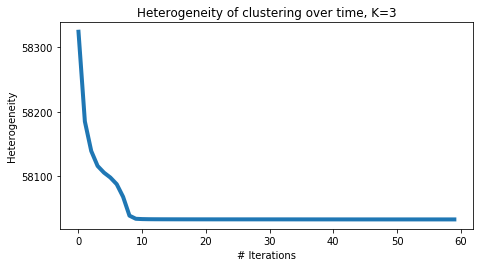

In [101]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

**Q1: (True/False) The clustering objective (heterogeneity) is non-increasing for this example.**

**Q2: Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running k-means, that would indicate: (choose one)**

1. k-means algorithm got stuck in a bad local minimum
2. There is a bug in the k-means code
3. All data points consist of exact duplicates
4. Nothing is wrong. The objective should generally go down sooner or later.

**Q3: Which of the cluster contains the greatest number of data points in the end?**

In [105]:
np.argmax(np.bincount(cluster_assignment))

2

## Beware of local maxima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

In [108]:
import sys

In [109]:
k = 10
heterogeneity = {}

import time
start = time.time()

for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400, 
                                          record_heterogeneity=None, verbose=False)
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    
    print("seed={0:06d}, heterogeneity={1:.5f}".format(seed, heterogeneity[seed]))
    sys.stdout.flush()

end = time.time()
print (end-start)

seed=000000, heterogeneity=57457.52442
seed=020000, heterogeneity=57533.20100
seed=040000, heterogeneity=57512.69257
seed=060000, heterogeneity=57466.97925
seed=080000, heterogeneity=57494.92990
seed=100000, heterogeneity=57484.42210
seed=120000, heterogeneity=57554.62410
412.126000166


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

**Q5: Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes?**

In [119]:
k = 10
heterogeneity = {}

import time
start = time.time()
max_cluster_assignment = []

for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400, 
                                          record_heterogeneity=None, verbose=False)
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    max_cluster_assignment.append(np.max(np.bincount(cluster_assignment)))
    
    print("seed={0:06d}, heterogeneity={1:.5f}".format(seed, heterogeneity[seed]))
    sys.stdout.flush()

end = time.time()
print (end-start)

print np.min(max_cluster_assignment)

seed=000000, heterogeneity=57457.52442
seed=020000, heterogeneity=57533.20100
seed=040000, heterogeneity=57512.69257
seed=060000, heterogeneity=57466.97925
seed=080000, heterogeneity=57494.92990
seed=100000, heterogeneity=57484.42210
seed=120000, heterogeneity=57554.62410
387.909999847
15779


One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [112]:
def smart_initialize(data, k, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx, :].toarray()
    
    # Compute distances from the first centroid chosen to all the other data points.
    squared_distances = pairwise_distances(data, centroids[0:1], metric="euclidean").flatten()**2
    
    for i in xrange(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughly speaking, a new centroid should be as far as from other centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx, :].toarray()
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric="euclidean")**2, axis=1)
    
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

In [113]:
k = 10
heterogeneity_smart = {}
start = time.time()

for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                          record_heterogeneity=None, verbose=False)
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print ("seed={0:06d}, heterogeneity={1:.5f}".format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()

end = time.time()
print (end - start)

seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839
462.157000065


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a box plot for each of these methods, indicating the spread of values produced by each method.

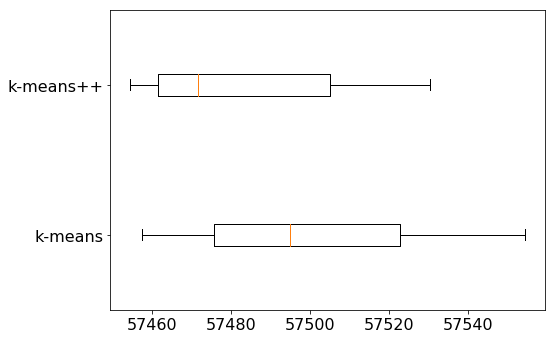

In [120]:
plt.figure(figsize=(8,5))
plt.boxplot([heterogeneity.values(), heterogeneity_smart.values()], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:
* On average, k-means++ produces a better clustering than Random initialization.
* Variation in clustering quality is smaller for k-means++.

**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

In [121]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float("inf")
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in xrange(num_runs):
        # Use UTC time if no seeds are provided.
        if seed_list is not None:
            seed = seed_list[i]
            np.random.seed(seed)
        else:
            seed = int(time.time())
            np.random.seed(seed)
            
        # Use k-means++ initialization
        initial_centroids = smart_initialize(data, k, seed=seed)
        
        # Run k-means
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter,
                                              record_heterogeneity=None, verbose=False)
        
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print ("seed={0:06d}, heterogeneity={1:.5f}".format(seed, heterogeneity[seed]))
            sys.stdout.flush()
            
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
            
    
    return final_centroids, final_cluster_assignment

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition. For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.) Let's explore this general trend for ourselves by performing the following analysis.

2
10
25
50
100


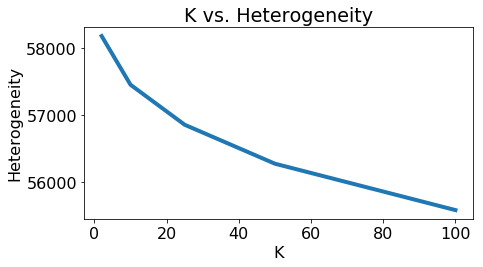

In [124]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7, 4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel("K")
    plt.ylabel("Heterogeneity")
    plt.title("K vs. Heterogeneity")
    plt.rcParams.update({"font.size": 16})
    plt.tight_layout()

filename = "E:\\Machine Learning\\U.W\\Cluster and Retrieval\\kmeans-arrays.npz"

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print k
        sys.stdout.flush()
        centroids[k] = lambda k=k: arrays["centroids_{0:d}".format(k)]
        cluster_assignment[k] = lambda k=k: arrays["cluster_assignment_{0:d}".format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k](), cluster_assignment[k]())
        heterogeneity_values.append(score)
        
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print("File not found. Skipping")

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? **Not at all!** As we will see in the following section, setting K too high may end up separating data points that are actually pretty alike. At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome. In the following section, we will learn how to detect a K set "too large".

## Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [125]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    print ("============================================================")
    
    # Visualize each cluster c
    for c in xrange(k):
        # Cluster heading
        print ("Cluster {0:d}   ".format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in xrange(5):   # Print each word along with the TF-IDF weight
            print ("{0:s}:{1:.3f}".format(map_index_to_word["category"][idx[i]], centroids[c, idx[i]])),
        print("")
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric="euclidean").flatten()
            distances[cluster_assignment!=c] = float("inf")   # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in xrange(8):
                text = " ".join(wiki[nearest_neighbors[i]]["text"].split(None, 25)[0:25])
                print ("\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}".format(wiki[nearest_neighbors[i]]["name"], 
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 0 else ""))
                
        print ("=============================================================")

Let us first look at the 2 cluster case (K=2).

In [126]:
visualize_document_clusters(wiki, tf_idf, centroids[2](), cluster_assignment[2](), 2, map_index_to_word)

Cluster 0    she:0.025 her:0.017 music:0.012 he:0.011 university:0.011 

* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda                          

Both clusters have mixed content, although cluster 1 is much purer than cluster 0:
* Cluster 0: artists, songwriters, professors, politicians, writers, etc.
* Cluster 1: baseball players, hockey players, soccer (association football) players, etc.

Top words of cluster 1 are all related to sports, whereas top words of cluster 0 show no clear pattern.

Roughly speaking, the entire dataset was divided into athletes and non-athletes. It would be better if we sub-divided non-atheletes into more categories. So let us use more clusters. How about `K=10`?

In [127]:
k = 10

visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k, map_index_to_word)

Cluster 0    film:0.020 art:0.014 he:0.011 book:0.010 television:0.010 

* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                                        0.97823
  paul swadel is a new 


* Catherine Hakim                                    0.96374
  catherine hakim born 30 may 1948 is a british sociologist who specialises in womens employ
  ment and womens issues she is currently a professorial research fellow

* Stephen Park Turner                                0.96405
  stephen turner is a researcher in social practice social and political theory and the phil
  osophy of the social sciences he is graduate research professor in

* Robert Bates (political scientist)                 0.96489
  robert hinrichs bates born 1942 is an american political scientist he is eaton professor o
  f the science of government in the departments of government and

* Georg von Krogh                                    0.96505
  georg von krogh was born in oslo norway he is a professor at eth zurich and holds the chai
  r of strategic management and innovation he
Cluster 5    football:0.076 coach:0.060 basketball:0.056 season:0.044 played:0.037 

* Todd Curley                           

Cluster 9    party:0.028 election:0.025 minister:0.025 served:0.021 law:0.019 

* Doug Lewis                                         0.96516
  douglas grinslade doug lewis pc qc born april 17 1938 is a former canadian politician a ch
  artered accountant and lawyer by training lewis entered the

* David Anderson (British Columbia politician)       0.96530
  david a anderson pc oc born august 16 1937 in victoria british columbia is a former canadi
  an cabinet minister educated at victoria college in victoria

* Lucienne Robillard                                 0.96679
  lucienne robillard pc born june 16 1945 is a canadian politician and a member of the liber
  al party of canada she sat in the house

* Bob Menendez                                       0.96686
  robert bob menendez born january 1 1954 is the senior united states senator from new jerse
  y he is a member of the democratic party first

* Mal Sandon                                         0.96706
  malcolm john mal sand

Clusters 0, 1, and 5 appear to be still mixed, but others are quite consistent in content.
* Cluster 0: artists, actors, film directors, playwrights
* Cluster 1: soccer (association football) players, rugby players
* Cluster 2: track and field athletes
* Cluster 3: baseball players
* Cluster 4: professors, researchers, scholars
* Cluster 5: Austrailian rules football players, American football players
* Cluster 6: female figures from various fields
* Cluster 7: composers, songwriters, singers, music producers
* Cluster 8: ice hockey players
* Cluster 9: politicians

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of baseball players. Increasing the number of clusters may split larger clusters. Another way to look at the size of the clusters is to count the number of articles in each cluster.

In [128]:
np.bincount(cluster_assignment[10]())

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,
        8926], dtype=int64)

**Q5: Which of the 10 clusters above contains the greatest number of articles?**

1. Cluster 0: artists, actors, film directors, playwrights
2. Cluster 4: professors, researchers, scholars
3. Cluster 5: Austrailian rules football players, American football players
4. Cluster 7: composers, songwriters, singers, music producers
5. Cluster 9: politicians

**Q6: Which of the 10 clusters contains the least number of articles?**

1. Cluster 1: soccer (association football) players, rugby players
2. Cluster 3: baseball players
3. Cluster 6: female figures from various fields
4. Cluster 7: composers, songwriters, singers, music producers
5. Cluster 8: ice hockey players

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25.

In [129]:
visualize_document_clusters(wiki, tf_idf, centroids[25](), cluster_assignment[25](), 25,
                            map_index_to_word)

Cluster 0    law:0.077 district:0.048 court:0.046 republican:0.038 senate:0.038 

* George B. Daniels                                  0.92779
  george benjamin daniels born 1953 is a united states federal judge for the united states d
  istrict court for the southern district of new yorkdaniels was

* William G. Young                                   0.92867
  william glover young born 1940 is a united states federal judge for the district of massac
  husetts young was born in huntington new york he attended

* Jean Constance Hamilton                            0.92969
  jean constance hamilton born 1945 is a senior united states district judge of the united s
  tates district court for the eastern district of missouriborn in

* Barry Sullivan (lawyer)                            0.92991
  barry sullivan is a chicago lawyer and as of july 1 2009 the cooney conway chair in advoca
  cy at loyola university chicago school of law

* James G. Carr                                      0.930


* J. Brian Atwood                                    0.96736
  john brian atwood born 25 july 1942 is a diplomat and former administrator of the us agenc
  y for international development from 2002 to 2010 he

* Ahmad Kamal                                        0.96789
  ahmed kamal born april 9 1938 is a retired pakistani diplomat most noted for his work at t
  he united nations he served as a professional

* Robert E. Hunter                                   0.96805
  robert edwards hunter born 1940 in cambridge massachusetts is a senior fellow at the cente
  r for transatlantic relations at the paul h nitze school of

* William Robert Graham                              0.96805
  william robert graham born june 15 1937 was chairman of president reagans general advisory
   committee on arms control from 1982 to 1985 a deputy administrator
Cluster 5    minister:0.160 prime:0.056 cabinet:0.044 party:0.043 election:0.042 

* Snyder Rini                                        0.89987
 


* Kai A. Konrad                                      0.88162
  kai a konrad born march 11 1961 in heidelberg is a german economist with his main research
   interest in public economicskonrad got his university degrees

* Maitreesh Ghatak                                   0.88228
  maitreesh ghatak born 7 february 1968 is a professor of economics at the london school of 
  economics he is an applied microeconomic theorist with research

* Robin Boadway                                      0.89334
  robin william boadway oc frsc born june 10 1943 is a canadian economist he holds the david
   smith chair at queens university in kingston ontario

* Richard Blundell                                   0.89680
  sir richard william blundell cbe fba born 1 may 1952 shorehambysea is a british economist 
  and econometricianblundell is the david ricardo professor of political economy

* Darius Lakdawalla                                  0.89684
  darius lakdawalla is the american director of re


* James Baldwin (baseball)                           0.90629
  james j baldwin jr born july 15 1971 is a former major league baseball pitcher he batted a
  nd threw righthanded in his 11season career he

* Joe Strong                                         0.90652
  joseph benjamin strong born september 9 1962 in fairfield california is a former major lea
  gue baseball pitcher who played for the florida marlins from 2000

* Kevin Nicholson (baseball)                         0.90657
  kevin ronald nicholson born march 29 1976 is a canadian baseball shortstop he played part 
  of the 2000 season for the san diego padres of

* Javier L%C3%B3pez (baseball)                       0.90662
  javier alfonso lpez born july 11 1977 is a puerto rican professional baseball pitcher for 
  the san francisco giants of major league baseball he is
Cluster 14    art:0.144 museum:0.076 gallery:0.056 artist:0.033 arts:0.031 

* John Walker (painter)                              0.86603
  john walker born

Cluster 18    poetry:0.055 novel:0.045 book:0.042 published:0.039 fiction:0.035 

* Kathleen Jones                                     0.94247
  kathleen jones born 1946 is an english poet and biographerborn and brought up on a hill fa
  rm in the north of england she moved to

* Enid Shomer                                        0.94502
  enid shomer is an american poet and fiction writer she is author of six poetry collections
   and two short story collections her poems have appeared

* Cynthia Cruz                                       0.94676
  cynthia cruz is a contemporary american poet her first collection of poems ruin was publis
  hed by alice james books in 2006 and reviewed by the

* William Heyen                                      0.94791
  william helmuth heyen born november 1 1940 is an american poet editor and literary critic 
  he was born in brooklyn new york and raised in

* Frank X. Gaspar                                    0.94795
  frank xavier gaspar is an amer


* Daniel Meyer (conductor)                           0.85471
  daniel meyer was born in cleveland ohio and has been conductor and musical director of sev
  eral prominent american orchestrashe is a graduate of denison university

* David Porcelijn                                    0.85612
  david porcelijn born 7 january 1947 in achtkarspelen is a dutch composer and conductordavi
  d porcelijn studied flute composition and conducting at the royal conservatoire of

* Karen Williams                                     0.85656
  karen williams is an american concert and opera soprano in 1985 she won the metropolitan o
  pera national council auditions making her stage debut at the

* Peter Er%C5%91s                                    0.85885
  hungarianamerican conductor peter sandor ers born 22 september 1932 budapest died 12 septe
  mber 2014 seattle attended the franz liszt academy of music where he studied
Cluster 23    basketball:0.120 coach:0.105 nba:0.065 head:0.042 season:0.040 

Looking at the representative examples and top words, we classify each cluster as follows. Notice the bolded items, which indicate the appearance of a new theme.
* Cluster 0: **lawyers, judges, legal scholars**
* Cluster 1: **professors, researchers, scholars (natural and health sciences)**
* Cluster 2: ice hockey players
* Cluster 3: politicans
* Cluster 4: **government officials**
* Cluster 5: politicans
* Cluster 6: **professors, researchers, scholars (social sciences and humanities)**
* Cluster 7: Canadian politicians
* Cluster 8: **car racers**
* Cluster 9: **economists**
* Cluster 10: track and field athletes
* Cluster 11: females from various fields
* Cluster 12: (mixed; no clear theme)
* Cluster 13: baseball players
* Cluster 14: **painters, sculptors, artists**
* Cluster 15: Austrailian rules football players, American football players
* Cluster 16: **musicians, composers**
* Cluster 17: soccer (association football) players, rugby players
* Cluster 18: **poets**
* Cluster 19: **film directors, playwrights**
* Cluster 20: **songwriters, singers, music producers**
* Cluster 21: **generals of U.S. Air Force**
* Cluster 22: **music directors, conductors**
* Cluster 23: **basketball players**
* Cluster 24: **golf players**

Indeed, increasing K achieved the desired effect of breaking up large clusters.  Depending on the application, this may or may not be preferable to the K=10 analysis.


**A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.**

**There is no golden rule for choosing K. It all depends on the particular application and domain we are in.**

**Q7: Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). How many of the 100 clusters have fewer than 236 articles, i.e. 0.4% of the dataset?**

In [134]:
bin = np.bincount(cluster_assignment[100]())

len(bin[bin<=236])

29